In [30]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn import ensemble
from sklearn.model_selection import KFold

from mlxtend.evaluate import bias_variance_decomp

1. Придумать двумерную вероятностную модель для двух классов. Это может быть смесь нормальных распределений (с различными параметрами) с числом компонент, большим чем число классов.

In [2]:
# Количество признаков для каждгого объекта
number_of_features = 5

In [3]:
def generate_dataframe(class1_count, class2_count):
    
    # Средние значения
    means1 = [0.25, 0.15, -0.22, 0.21, 0.27]
    means2 = [0.23, -0.2, 0.28, -0.23, 0.25]
    # Стандартные отклонения
    devs1 = [0.13, 0.22, 0.13, 0.22, 0.51]
    devs2 = [0.15, 0.22, 0.42, 0.21, 0.23]
    
    features1 = np.random.normal(loc = means1, scale = devs1, size=[class1_count, number_of_features])
    features2 = np.random.normal(loc = means2, scale = devs2, size=[class2_count, number_of_features])
    
    df = pd.DataFrame()
    df['class'] = np.concatenate((np.full(class1_count, 0), np.full(class2_count, 1)))
    
    for i in range(0, number_of_features):
        df['feature' + str(i)] = np.concatenate((features1[:, i], features2[:, i]))
        
    return df

In [4]:
df = generate_dataframe(100, 100)
df

,class,feature0,feature1,feature2,feature3,feature4
0,0,0.313872,-0.317969,-0.177604,0.565647,1.022420
1,0,0.266393,0.321579,-0.065604,-0.054224,-0.179636
2,0,0.660435,0.074103,-0.367024,-0.048699,-0.037904
3,0,0.540730,0.065366,-0.199245,0.352807,-0.411330
4,0,0.206744,0.337197,-0.174619,0.288899,-0.121703
...,...,...,...,...,...,...
195,1,0.311431,-0.172681,0.183493,-0.745004,-0.089292
196,1,0.126806,-0.069366,0.330927,-0.255811,0.408873
197,1,0.181707,-0.222145,0.172533,-0.067073,0.402902
198,1,0.156421,-0.247067,-0.218578,-0.167749,0.345061


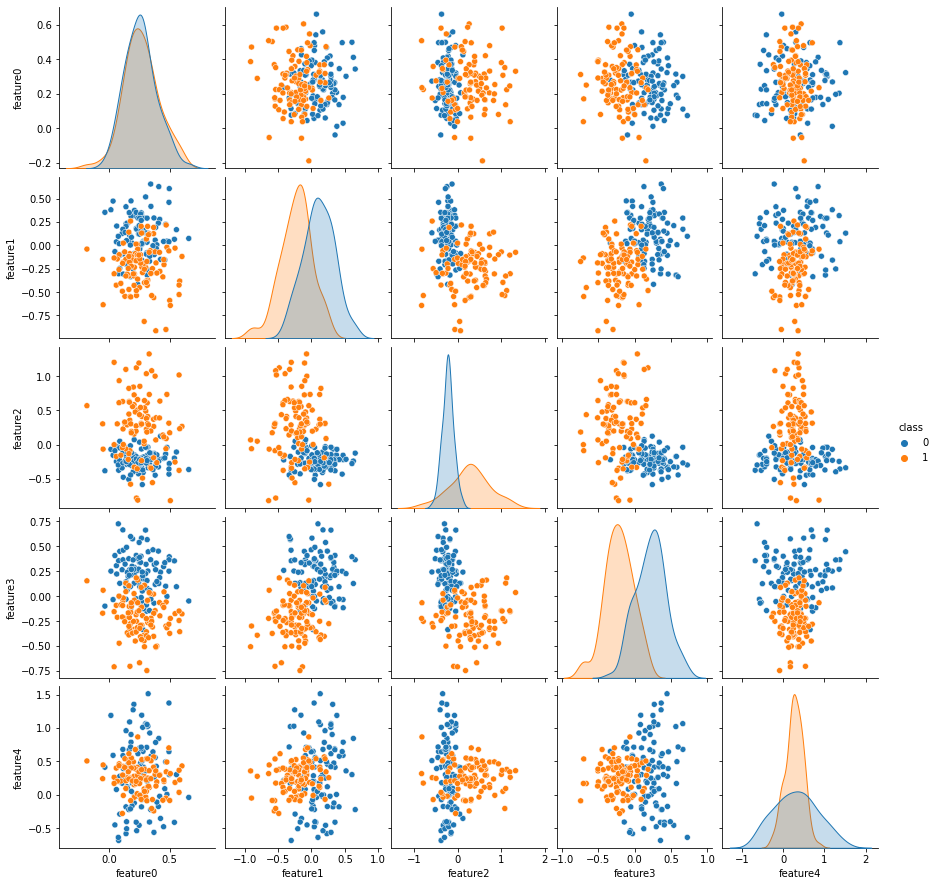

In [5]:
sns.pairplot(df, hue='class')

2. Задать параметры: размер обучающей выборки (порядка 100 объектов), число разбиений кроссвалидации. Выбрать метод классификации и задать его параметры.
3. Повторять шаги 4–7 заданное число раз (50–100).
4. Сгенерировать обучающую выборку заданного размера.
5. Построить решающую функцию. Вычислить эмпирический риск (число ошибок на обучении).
6. Сгенерировать контрольную выборку достаточно большого размера (больше 10000 объектов). Вычислить оценку вероятности ошибочной классификации.
7. Вычислить оценку вероятности ошибочной классификации методом скользящего экзамена (на исходной обучающей выборке).


Эмпирический риск:
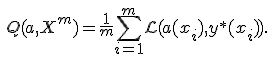

Вероятность ошибочной классификации:
p = test_errors_count / all_tests_samples_count

Оценки вероятности ошибочной классификации методом скользящего среднего (кросс-валидация):
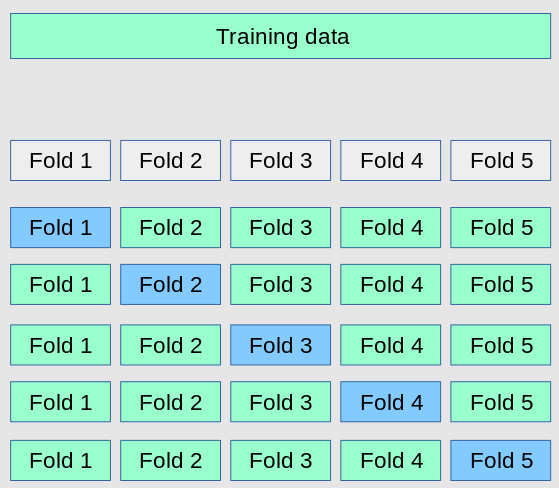

In [6]:
# parameters:
# *n_estimators* - кол-во дереьев решений
# *max_depth* - ограничение на максимальную глубину дерева
# *max_samples* - количество объектов для обучения каждого дерева

classifier = ensemble.RandomForestClassifier(n_estimators=30, max_depth=10, random_state=0, max_samples=50)

,empirical_risk,error_prob,moving_average
0,0.040,0.06150,0.080
1,0.015,0.07915,0.070
2,0.020,0.05350,0.085
3,0.035,0.05895,0.095
4,0.015,0.05740,0.100
...,...,...,...
65,0.020,0.05895,0.060
66,0.035,0.05555,0.060
67,0.030,0.05735,0.075
68,0.025,0.05935,0.085


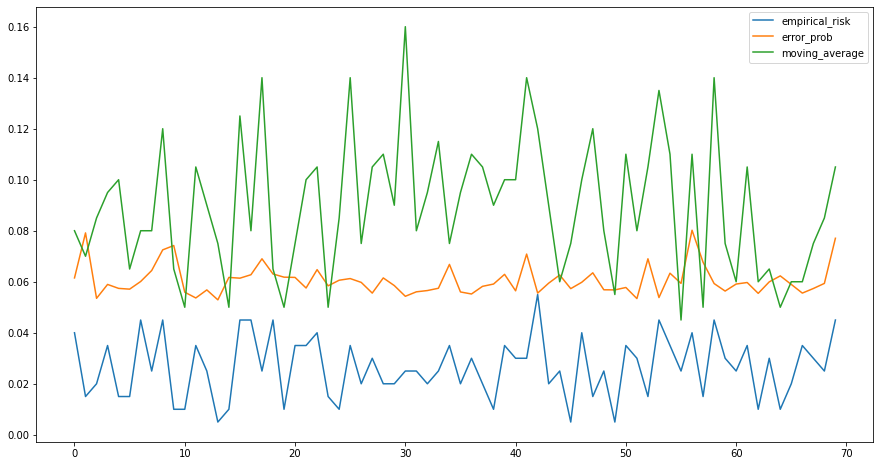

In [7]:
def count_errors(preds, gts):
    errors = 0
    for pred, gt in zip(preds, gts):
        if pred != gt:
            errors += 1
    return errors

def calculate_statistics(classifier):
    n = 70

    results = pd.DataFrame()
    results['empirical_risk'] = np.zeros(n)
    results['error_prob'] = np.zeros(n)
    results['moving_average'] = np.zeros(n)

    for i in range(n):
        df = generate_dataframe(100, 100)

        X = df.iloc[:, 1:]
        y = df['class']

        classifier.fit(X, y)
        predict = classifier.predict(X)
        
        # Расчет эмпирического риска
        errors = count_errors(predict, y)
        results['empirical_risk'][i] = errors / len(predict)
        
        # Расчет оценки вероятности ошибочной классификации
        # Генерируем новую выборку из большего кол-ва объектов
        df_test = generate_dataframe(10000, 10000)
        predict = classifier.predict(df_test.iloc[:, 1:])
        results['error_prob'][i] = count_errors(predict, df_test['class']) / len(predict)
        
        # Расчет оценки вероятности ошибочной классификации методом скользящего среднего:
        # Усредняем значение вероятностей полученных для каждого k-fold
        errors = []
        kf = KFold(n_splits=5, shuffle=False)
        for train_index, test_index in kf.split(y):
            X_train_sub = np.take(X, train_index, axis=0)
            X_test_sub = np.take(X, test_index, axis=0)
            y_train_sub = np.take(y, train_index)
            y_test_sub = np.take(y, test_index)
            classifier.fit(X_train_sub, y_train_sub)
            predict = classifier.predict(X_test_sub)
            errors.append(count_errors(predict, y_test_sub) / len(predict))

        results['moving_average'][i] = np.mean(errors)

    return results


res = calculate_statistics(classifier)
plt.rcParams['figure.figsize'] = (15,8)
plt.plot(res['empirical_risk'])
plt.plot(res['error_prob'])
plt.plot(res['moving_average'])
plt.legend(('empirical_risk', 'error_prob', 'moving_average'), loc='upper right')
plt.show
res

9. Вычислить средние и стандартные отклонения по каждому столбцу.

In [8]:
statistics = pd.DataFrame()
statistics['metric'] = ['mean', 'std_dev']
statistics['empirical_risk'] = [ np.mean(res.iloc[:,0]) , np.std(res.iloc[:,0])]
statistics['error_prob'] = [ np.mean(res.iloc[:,1]) , np.std(res.iloc[:,1])]
statistics['moving_average'] = [ np.mean(res.iloc[:,2]) , np.std(res.iloc[:,2])]

statistics

,metric,empirical_risk,error_prob,moving_average
0,mean,0.026500,0.060628,0.089357
1,std_dev,0.011993,0.005890,0.026240


10. Провести аналогичное моделирование, изменив вероятностную модель, или метод классификации, или параметры метода.
11. Сделать выводы, насколько выбранный метод классификации и его параметры соответствуют сложности модели и объёму выборки.


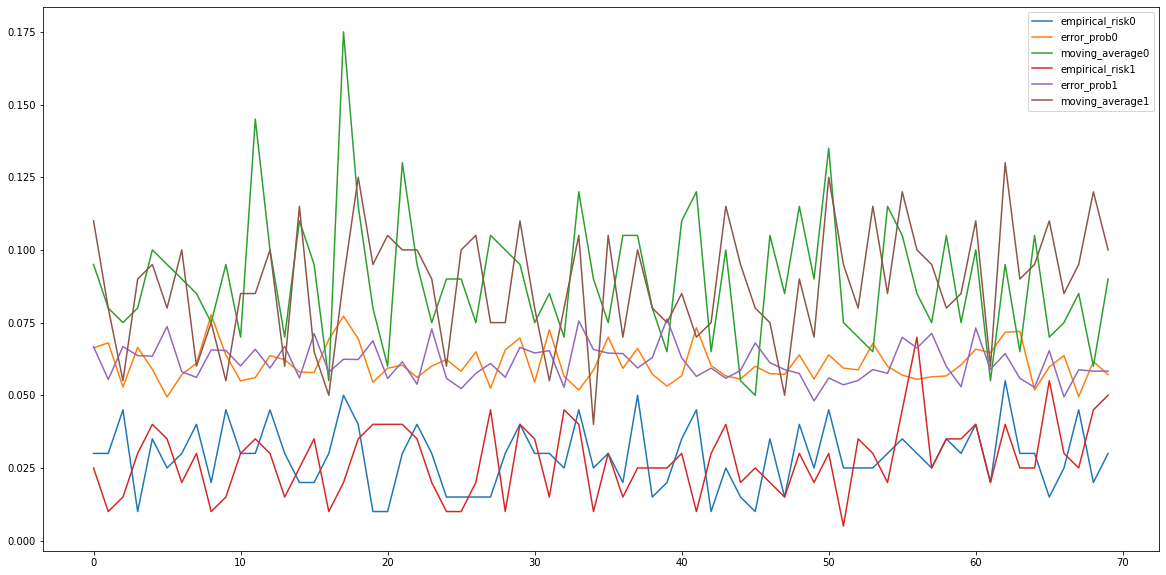

,metric,empirical_risk0,error_prob0,moving_average0,empirical_risk1,error_prob1,moving_average1
0,mean,0.028786,0.060907,0.089571,0.028071,0.061336,0.088000
1,std_dev,0.010936,0.006309,0.022341,0.012372,0.006228,0.020007


In [23]:
# max_depth

classifiers = [ensemble.RandomForestClassifier(n_estimators=30, max_depth=10, random_state=0, max_samples=50),
               ensemble.RandomForestClassifier(n_estimators=30, max_depth=50, random_state=0, max_samples=50)]


statistics = pd.DataFrame()
plt.rcParams['figure.figsize'] = (20,10)
for i in range(len(classifiers)):
    res = calculate_statistics(classifiers[i])
    
    res['empirical_risk' + str(i)] = res['empirical_risk']
    res['error_prob' + str(i)] = res['error_prob']
    res['moving_average' + str(i)] = res['moving_average']
    
    plt.plot(res['empirical_risk' + str(i)])
    plt.plot(res['error_prob' + str(i)])
    plt.plot(res['moving_average' + str(i)]) 
    statistics['metric'] = ['mean', 'std_dev']
    statistics['empirical_risk' + str(i)] = [ np.mean(res.iloc[:,0]) , np.std(res.iloc[:,0])]
    statistics['error_prob' + str(i)] = [ np.mean(res.iloc[:,1]) , np.std(res.iloc[:,1])]
    statistics['moving_average' + str(i)] = [ np.mean(res.iloc[:,2]) , np.std(res.iloc[:,2])]
    
legend = []
for i in range(len(classifiers)):
    legend.append('empirical_risk' + str(i))
    legend.append('error_prob' + str(i))
    legend.append('moving_average' + str(i))
    
plt.legend((legend), loc='upper right')
plt.show()

statistics

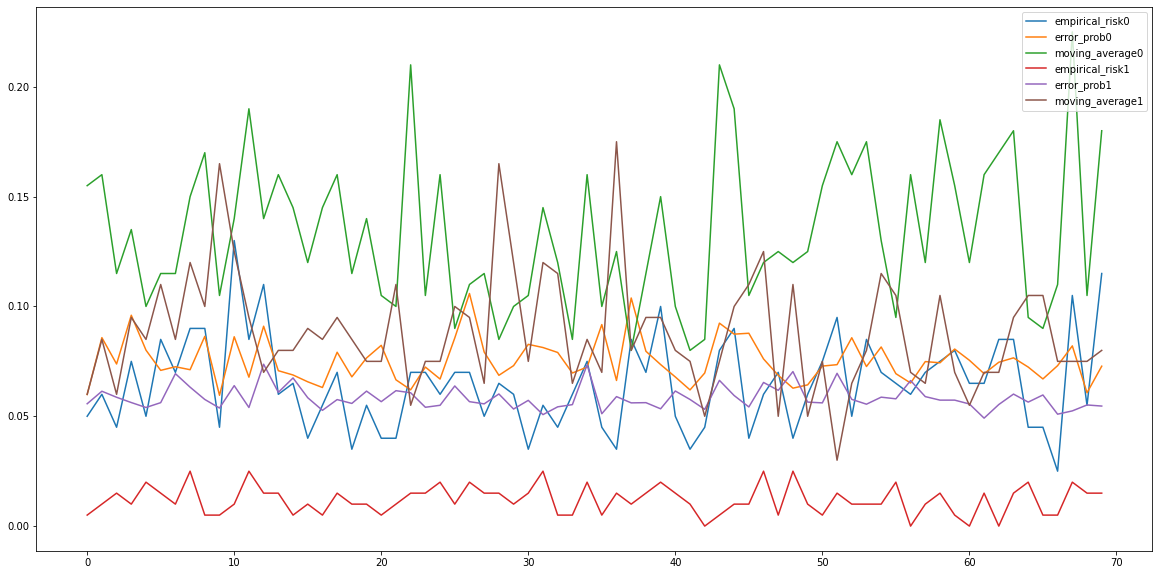

,metric,empirical_risk0,error_prob0,moving_average0,empirical_risk1,error_prob1,moving_average1
0,mean,0.065000,0.075287,0.133500,0.011929,0.058401,0.088071
1,std_dev,0.020942,0.009804,0.034251,0.006453,0.005221,0.026285


In [25]:
# max_samples

classifiers = [ensemble.RandomForestClassifier(n_estimators=30, max_depth=10, random_state=0, max_samples=10),
               ensemble.RandomForestClassifier(n_estimators=30, max_depth=10, random_state=0, max_samples=100)]


statistics = pd.DataFrame()
plt.rcParams['figure.figsize'] = (20,10)
for i in range(len(classifiers)):
    res = calculate_statistics(classifiers[i])
    
    res['empirical_risk' + str(i)] = res['empirical_risk']
    res['error_prob' + str(i)] = res['error_prob']
    res['moving_average' + str(i)] = res['moving_average']
    
    plt.plot(res['empirical_risk' + str(i)])
    plt.plot(res['error_prob' + str(i)])
    plt.plot(res['moving_average' + str(i)]) 
    statistics['metric'] = ['mean', 'std_dev']
    statistics['empirical_risk' + str(i)] = [ np.mean(res.iloc[:,0]) , np.std(res.iloc[:,0])]
    statistics['error_prob' + str(i)] = [ np.mean(res.iloc[:,1]) , np.std(res.iloc[:,1])]
    statistics['moving_average' + str(i)] = [ np.mean(res.iloc[:,2]) , np.std(res.iloc[:,2])]
    
legend = []
for i in range(len(classifiers)):
    legend.append('empirical_risk' + str(i))
    legend.append('error_prob' + str(i))
    legend.append('moving_average' + str(i))
    
plt.legend((legend), loc='upper right')
plt.show()

statistics

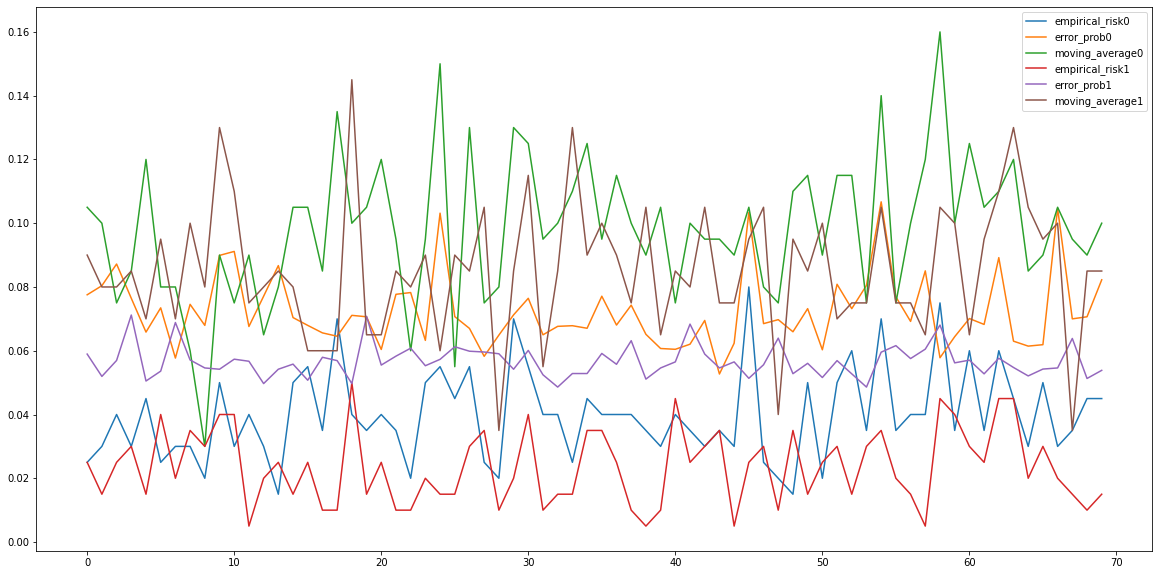

,metric,empirical_risk0,error_prob0,moving_average0,empirical_risk1,error_prob1,moving_average1
0,mean,0.039786,0.072459,0.098214,0.023571,0.056709,0.085429
1,std_dev,0.014204,0.011354,0.022249,0.011623,0.004980,0.020852


In [26]:
# n_estimators

classifiers = [ensemble.RandomForestClassifier(n_estimators=10, max_depth=10, random_state=0, max_samples=50),
               ensemble.RandomForestClassifier(n_estimators=100, max_depth=10, random_state=0, max_samples=50)]


statistics = pd.DataFrame()
plt.rcParams['figure.figsize'] = (20,10)
for i in range(len(classifiers)):
    res = calculate_statistics(classifiers[i])
    
    res['empirical_risk' + str(i)] = res['empirical_risk']
    res['error_prob' + str(i)] = res['error_prob']
    res['moving_average' + str(i)] = res['moving_average']
    
    plt.plot(res['empirical_risk' + str(i)])
    plt.plot(res['error_prob' + str(i)])
    plt.plot(res['moving_average' + str(i)]) 
    statistics['metric'] = ['mean', 'std_dev']
    statistics['empirical_risk' + str(i)] = [ np.mean(res.iloc[:,0]) , np.std(res.iloc[:,0])]
    statistics['error_prob' + str(i)] = [ np.mean(res.iloc[:,1]) , np.std(res.iloc[:,1])]
    statistics['moving_average' + str(i)] = [ np.mean(res.iloc[:,2]) , np.std(res.iloc[:,2])]
    
legend = []
for i in range(len(classifiers)):
    legend.append('empirical_risk' + str(i))
    legend.append('error_prob' + str(i))
    legend.append('moving_average' + str(i))
    
plt.legend((legend), loc='upper right')
plt.show()

statistics

12. Факультативно: вычислить смещение и разброс (bias-variance decomposition)

Bias — характеризует недообучение. Его высокое значение говорит о том, что алгоритм учитывает не все связи между функциями и целевыми выходными данными.

Variance — характеризует переобучение. Высокий variance говорит о чувствительности модели к небольшим колебаниям обучающей выборки.

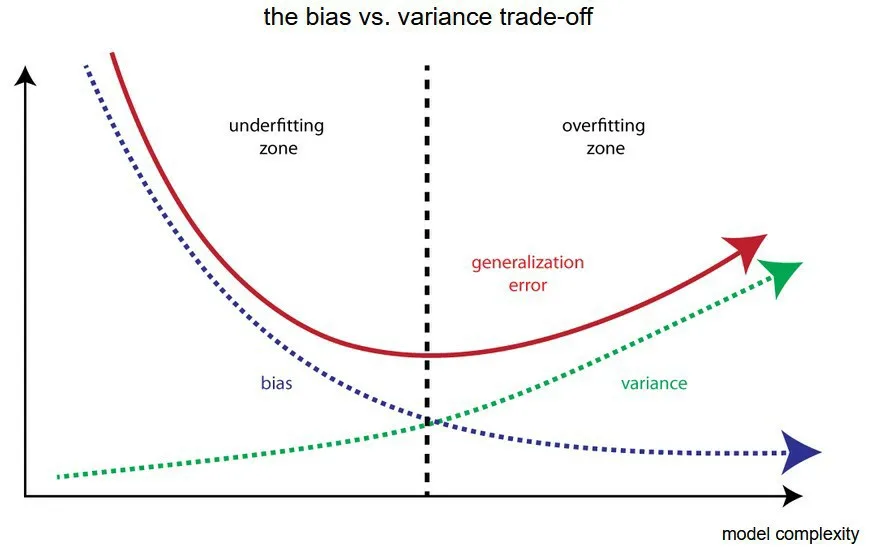

In [50]:
# Аналогично п. 4-7 расчитываем bias & variance для всех оценок
def calculate_bias_variance(classifiers):
    size = len(classifiers)
    
    res = pd.DataFrame()
    res['classifier'] = np.zeros(size)
    res['empirical_risk_bias'] = np.zeros(size)
    res['empirical_risk_var'] = np.zeros(size)
    res['error_prob_bias'] = np.zeros(size)
    res['error_prob_var'] = np.zeros(size)
    res['moving_average_bias'] = np.zeros(size)
    res['moving_average_var'] = np.zeros(size)

    for i, classifier in enumerate(classifiers):
        res.loc[i, 'classifier'] = i

        frame = generate_dataframe(100, 100)
        
        X = df.iloc[:, 1:]
        y = df['class']
        
        _, bias, var = bias_variance_decomp(classifier, X.values, y.values, X.values, y.values, loss='mse', random_seed=0)
        res.loc[i, 'empirical_risk_bias'] = bias
        res.loc[i, 'empirical_risk_var'] = var
        
        df_test = generate_dataframe(10000, 10000)
        X_test = df_test.iloc[:,1:]
        y_test = df_test['class']
        _, bias, var = bias_variance_decomp(classifier, X.values, y.values, X_test.values, y_test.values, loss='mse', random_seed=0)
        res.loc[i, 'error_prob_bias'] = bias
        res.loc[i, 'error_prob_var'] = var
        
        biases = []
        variances = []
        kf = KFold(n_splits=5, shuffle=False)
        for train_index, test_index in kf.split(y):
            X_train_sub = np.take(X, train_index, axis=0)
            X_test_sub = np.take(X, test_index, axis=0)
            y_train_sub = np.take(y, train_index)
            y_test_sub = np.take(y, test_index)

            mse, bias, variance = bias_variance_decomp(classifier, X_train_sub.values, y_train_sub.values, X_test_sub.values, y_test_sub.values, loss='mse', random_seed=0)
            biases.append(bias)
            variances.append(variance)

        res.loc[i, 'moving_average_bias'] = np.mean(biases)
        res.loc[i, 'moving_average_var'] = np.mean(variances)
    
    return res

def draw_diagram(x, y, data):
    df = data[[x]+y].melt(id_vars=[x], value_name='values', var_name='legend')
    sns.catplot(data=df, x=x, y='values', hue='legend', kind="bar")

In [44]:
classifiers = [ensemble.RandomForestClassifier(n_estimators=1, max_depth=10, random_state=0, max_samples=50),
               ensemble.RandomForestClassifier(n_estimators=10, max_depth=10, random_state=0, max_samples=50),
               ensemble.RandomForestClassifier(n_estimators=20, max_depth=10, random_state=0, max_samples=50),
               ensemble.RandomForestClassifier(n_estimators=50, max_depth=10, random_state=0, max_samples=50),
               ensemble.RandomForestClassifier(n_estimators=100, max_depth=10, random_state=0, max_samples=50)]
statistics = calculate_bias_variance(classifiers)
statistics

,classifier,empirical_risk_bias,empirical_risk_var,error_prob_bias,error_prob_var,moving_average_bias,moving_average_var
0,0.0,0.033701,0.077174,0.052185,0.082809,0.078768,0.099507
1,1.0,0.016825,0.028300,0.040421,0.032038,0.065174,0.044251
2,2.0,0.014583,0.022917,0.038904,0.025882,0.066063,0.037037
3,3.0,0.012811,0.018839,0.039473,0.020050,0.067378,0.030897
4,4.0,0.012703,0.017872,0.038790,0.017700,0.069532,0.028493


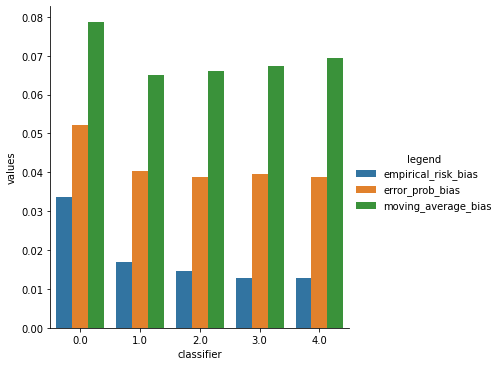

In [51]:
# bias
draw_diagram('classifier', ['empirical_risk_bias', 'error_prob_bias', 'moving_average_bias'], statistics)

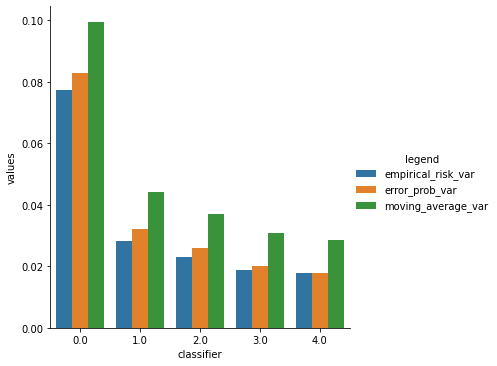

In [52]:
# variance
draw_diagram('classifier', ['empirical_risk_var', 'error_prob_var', 'moving_average_var'], statistics)

In [59]:
classifiers = [ensemble.RandomForestClassifier(n_estimators=30, max_depth=10, random_state=0, max_samples=10),
               ensemble.RandomForestClassifier(n_estimators=30, max_depth=10, random_state=0, max_samples=20),
               ensemble.RandomForestClassifier(n_estimators=30, max_depth=10, random_state=0, max_samples=50),
               ensemble.RandomForestClassifier(n_estimators=30, max_depth=10, random_state=0, max_samples=80),
               ensemble.RandomForestClassifier(n_estimators=30, max_depth=10, random_state=0, max_samples=100)]
statistics = calculate_bias_variance(classifiers)
statistics

,classifier,empirical_risk_bias,empirical_risk_var,error_prob_bias,error_prob_var,moving_average_bias,moving_average_var
0,0.0,0.037117,0.032308,0.044251,0.032233,0.097666,0.056109
1,1.0,0.025578,0.023397,0.042907,0.025557,0.079863,0.042137
2,2.0,0.013122,0.019903,0.040261,0.022034,0.064526,0.033624
3,3.0,0.008853,0.018247,0.040870,0.021972,0.062174,0.032776
4,4.0,0.007418,0.017657,0.040285,0.022156,0.060246,0.032279


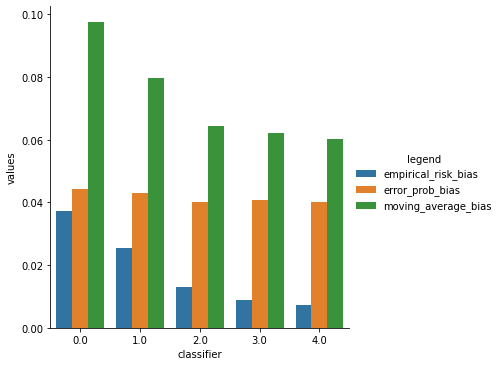

In [60]:
# bias
draw_diagram('classifier', ['empirical_risk_bias', 'error_prob_bias', 'moving_average_bias'], statistics)

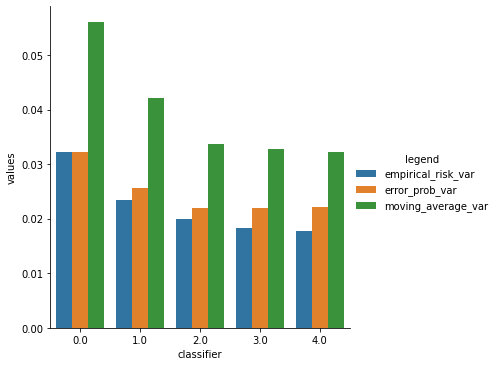

In [61]:
# variance
draw_diagram('classifier', ['empirical_risk_var', 'error_prob_var', 'moving_average_var'], statistics)